# Sheet 4

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

## 1 Learning with pytorch

(a)

In [2]:
# TODO: manual check of intermediate gradients with torch.autograd.grad

(b)

In [3]:
# TODO: Adam steps

In [4]:
# TODO: Plot the loss

(c)

In [5]:
# TODO: Compute gradients

In [6]:
# TODO: Plot gradients and compare to solution for x1 from part (b)

# 2) Amplitude Regression

In [2]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data04"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-2-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data04

100%|██████████| 11/11 [00:00<00:00, 32.86it/s]


 Datentr�ger in Laufwerk C: ist Windows
 Volumeseriennummer: DA64-9591

 Verzeichnis von c:\Users\Games\OneDrive\Desktop\MLP\mlph2023-Exercises\data04

30.11.2023  14:59    <DIR>          .
30.11.2023  11:35    <DIR>          ..
30.11.2023  11:35    <DIR>          tutorial-2-data
30.11.2023  14:51        55.093.854 tutorial-2-data (1).zip
30.11.2023  14:53        55.093.854 tutorial-2-data (2).zip
30.11.2023  14:59        55.093.854 tutorial-2-data (3).zip
30.11.2023  11:35        55.093.854 tutorial-2-data.zip
               4 Datei(en),    220.375.416 Bytes
               3 Verzeichnis(se), 13.590.605.824 Bytes frei


In [3]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


(a)

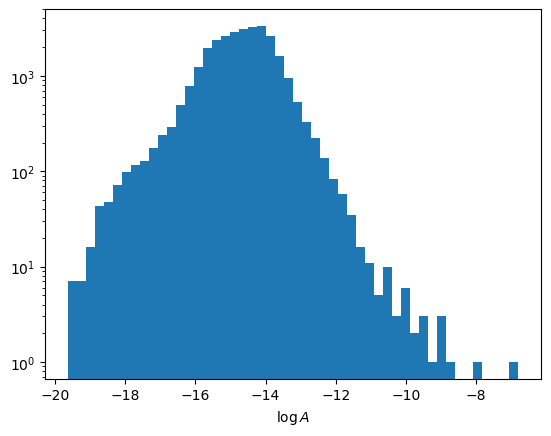

In [4]:
# TODO: Plot amplitudes
plt.yscale("log")
plt.hist(np.log(trn_amp), bins=50)
plt.xlabel(r"$\log A$")
plt.show()

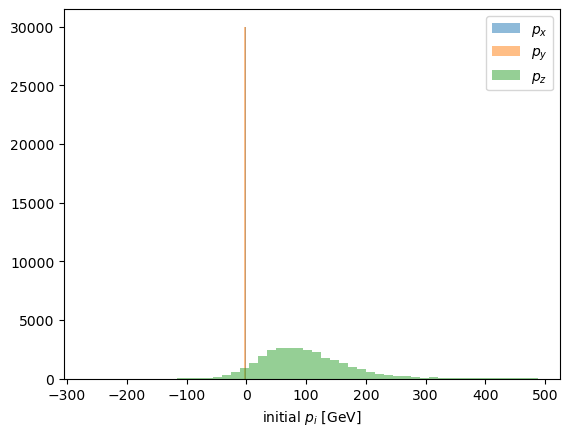

In [5]:
# TODO: Plot incoming momenta
def inc_momenta(data,i):
    return data[:,0,i]+data[:,1,i]
plt.hist(inc_momenta(trn_dat, 1), label=r"$p_x$", alpha=.5, bins=50)
plt.hist(inc_momenta(trn_dat, 2), label=r"$p_y$", alpha=.5, bins=50)
plt.hist(inc_momenta(trn_dat, 3), label=r"$p_z$", alpha=.5, bins=50)
plt.xlabel(r"initial $p_i$ [GeV]")
plt.legend()
plt.show()

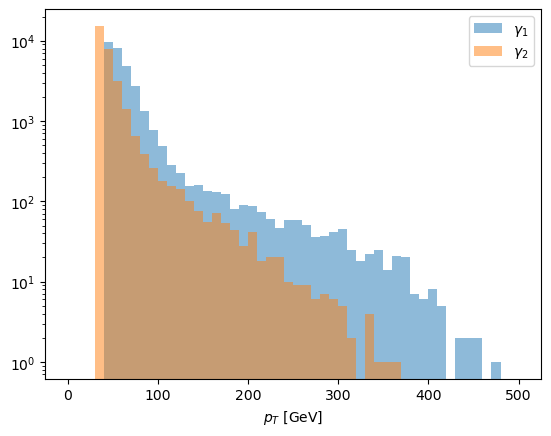

In [6]:
# TODO: Plot photon pTs
def get_pt(fv):
    """ returns p_T of given four vector """
    ptsq = np.round(fv[:, 1]**2 + fv[:, 2]**2, 5)
    return np.sqrt(ptsq)
plt.yscale("log")
plt.hist(get_pt(trn_dat[:,2]), alpha=.5, range=(0, 500), label=r"$\gamma_1$", bins=50)
plt.hist(get_pt(trn_dat[:,3]), alpha=.5, range=(0, 500), label=r"$\gamma_2$", bins=50)
plt.xlabel(r"$p_T$ [GeV]")
plt.legend()
plt.show()

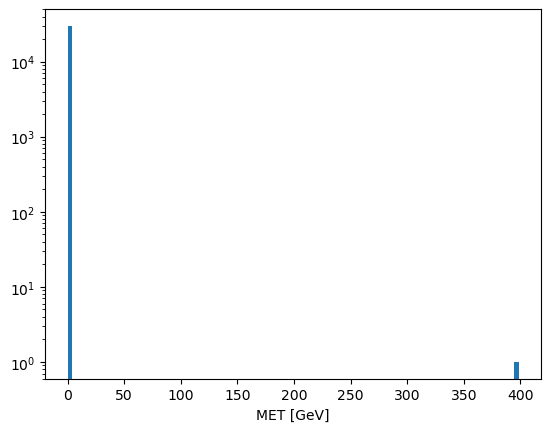

In [7]:
# TODO: Plot MET
def get_met(fv):
    """ returns MET of the event"""
    return np.sqrt(np.sum(fv[:, :, 1], axis=1)**2
                   +np.sum(fv[:, :, 2], axis=1)**2)
plt.yscale("log")
plt.hist(get_met(trn_dat), bins=100)
plt.xlabel(r"MET [GeV]")
plt.show()

(b)

In [8]:
# flatten datasets
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

In [9]:
# TODO: Implement preprocessing
def preprocess_x(x_in, mean=None, std=None):
    x = x_in.copy() # do not overwrite
    if mean is None or std is None:
        mean = x.mean(keepdims=True)
        std = x.std(keepdims=True)
    x = (x - mean) / std # standardize
    assert np.isfinite(x).all() # check for nans and infs
    return torch.Tensor(x).float(), mean, std # create torch tensors
    
def preprocess_A(A_in, mean=None, std=None):
    A = A_in.copy()
    A = np.log(A)
    if mean is None or std is None:
        mean = A.mean(keepdims=True)
        std = A.std(keepdims=True)
    A = (A - mean) / std
    assert np.isfinite(A).all() 
    return torch.tensor(A).float().unsqueeze(-1), mean, std

def undo_preprocess_A(A_in, mean, std):
    A = A_in.copy()
    A = A * std + mean
    A = np.exp(A)
    return A

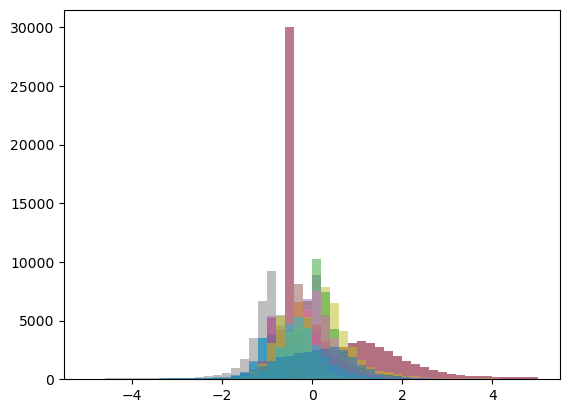

In [10]:
# check that network inputs are O(1)
for i in range(20):
    plt.hist(preprocess_x(trn_datf,None,None)[0][:,i], range=(-5,5), alpha=.5, bins=50)
plt.hist(preprocess_A(trn_amp)[0][:,0], range=(-5,5), alpha=.5, bins=50)
plt.show()

In [11]:
# TODO: Implement dataset class
class amp_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, amp):
        self.data=data
        self.amp=amp
    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx],self.amp[idx]

In [12]:
# create datasets and dataloaders
trn_datfp, mean_x, std_x = preprocess_x(trn_datf)
val_datfp, _, _ = preprocess_x(val_datf, mean_x, std_x)
tst_datfp, _, _ = preprocess_x(tst_datf, mean_x, std_x)

trn_ampp, mean_A, std_A = preprocess_A(trn_amp)
val_ampp, _, _ = preprocess_A(val_amp, mean_A, std_A)
tst_ampp, _, _ = preprocess_A(tst_amp, mean_A, std_A)

trn_dataset = amp_dataset(trn_datfp, trn_ampp)
val_dataset = amp_dataset(val_datfp, val_ampp)
tst_dataset = amp_dataset(tst_datfp, tst_ampp)

batch_size = 64
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
tst_dataloader = torch.utils.data.DataLoader(tst_dataset, batch_size=batch_size, shuffle=False)

(c)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [14]:
# TODO: Implement network
class amp_net(nn.Module):
    
    def __init__(self, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        super(amp_net, self).__init__()
        assert n_layers>=2
        layers=[]
        layers.append(nn.Linear(ipt_dim,hdn_dim))
        layers.append(nn.ReLU())
        for i in range(n_layers-2):
            layers.append(nn.Linear(hdn_dim,hdn_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hdn_dim,opt_dim))
        self.linear_relu_stack = nn.Sequential(*layers)
    def forward(self, x):
        output=self.linear_relu_stack(x)
        return output

In [15]:
# TODO: create network
model = amp_net(n_layers=4)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 2817 trainable parameters


In [16]:
# take first batch from train loader
x, A = next(iter(trn_dataloader))
print(x.shape, A.shape)

torch.Size([64, 20]) torch.Size([64, 1])


In [17]:
# TODO: Train network on first batch for 10000 iterations
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
n_iter=10000
losses=[]
for i in range(n_iter):
    optimizer.zero_grad()
    pred=model(x)
    loss=loss_fn(pred,A)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i%1000==0:
        print(f"{i} / {n_iter}")

0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000


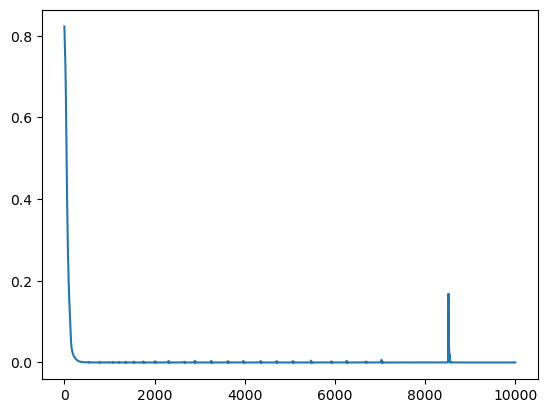

In [18]:
# TODO: Plot loss
plt.plot(range(n_iter),losses)

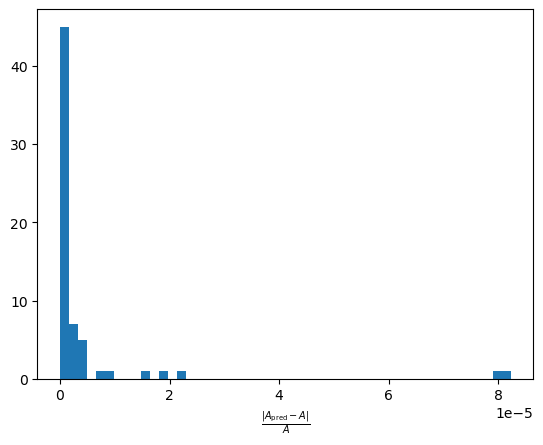

In [19]:
# TODO: Plot (A_predicted - A_true) / A_true
pred = model(x)
diff = torch.abs((pred.detach() - A) / A).cpu().numpy()

plt.hist(diff, bins=50)
plt.xlabel(r"$\frac{|A_\mathrm{pred}-A|}{A}$")
plt.show()

(d)

In [37]:
# TODO: Train network on the full training dataset
model=amp_net()
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
def training_epoch(dataloader,losses,model,loss_fn):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if epoch%10==0:
            print(f"{epoch} / {100}")
    return losses
def val_epoch(dataloader,losses,model,loss_fn):
    losses_epoch=[]
    with torch.no_grad():
        
n_epoch=100
model.train()
losses=[]
val_losses=[]
for epoch in range(n_epoch):
    training_epoch(trn_dataloader,losses,model,loss_fn)
    
    

0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
70 / 100

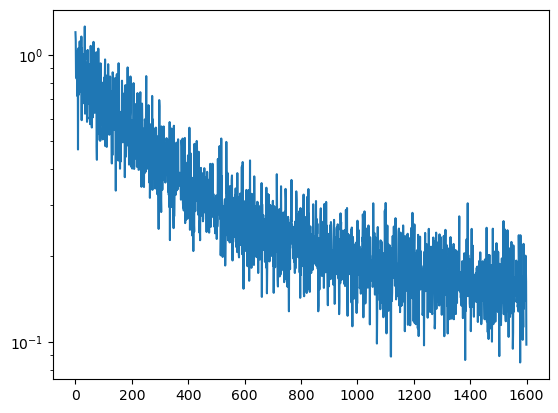

In [38]:
# TODO: Plot loss and amplitude histogram
plt.yscale('log')
plt.plot(range(len(losses)),losses)

(e)

In [28]:
# TODO: create dataloaders with reduced dataset
trn_dataset = amp_dataset(trn_datfp[:1000,:], trn_ampp[:1000,:])
val_dataset = amp_dataset(val_datfp, val_ampp)
tst_dataset = amp_dataset(tst_datfp, tst_ampp)

batch_size = 64
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
tst_dataloader = torch.utils.data.DataLoader(tst_dataset, batch_size=batch_size, shuffle=False)

In [29]:
# TODO: Train model on reduced dataset
# TODO: Train network on the full training dataset
model=amp_net()
loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
losses=[]
for epoch in range(100):
    model.train()  # Setze das Modell in den Trainingsmodus
    for inputs, labels in trn_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if epoch%10==0:
            print(f"{epoch} / {100}")

0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
0 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
10 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
20 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
30 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
40 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
50 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
60 / 100
70 / 100

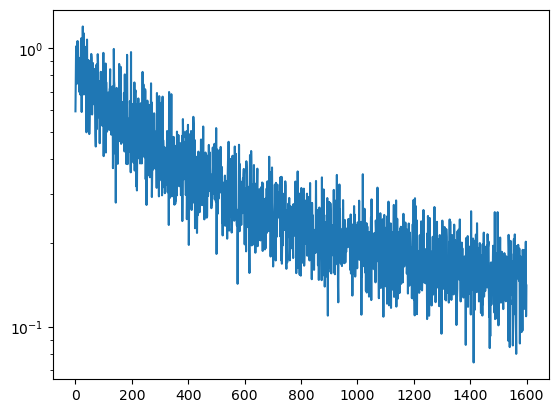

In [30]:
plt.yscale('log')
plt.plot(range(len(losses)),losses)

In [29]:
# TODO: Evaluate model

In [30]:
# TODO: Implement your regularization approach, train a model and evaluate it